# Algoritmo cuántico de Shor aplicado al caso N=15

He seguido el tutorial de Qiskit de IBM https://qiskit.org/textbook/ch-algorithms/shor.html

En el readme de mi repositorio de GitHub he redactado como funciona el proceso matemáticamente https://github.com/juanki98/Algoritmo-de-Shor-y-variantes/blob/main/README.md

In [137]:
#Hacemos todos los imports necesarios
import matplotlib.pyplot as plt
import numpy as np
from qiskit import QuantumCircuit, Aer, transpile, assemble #Importamos las funciones de Qiskit que nos permitiran
from qiskit.visualization import plot_histogram
from math import gcd
from numpy.random import randint
import pandas as pd
from fractions import Fraction #Para las fracciones continuas

## 1. Búsqueda del período

Sea f la función periódica tal que:

$$ f(x) = a^x \bmod{N}$$

donde $a$ y $N$ son enteros positivos, $a$ es menor que $N$ y no tienen factores comunes. El período, u orden ($r$), es el entero más pequeño (distinto de cero) tal que:

$$a^r \bmod N = 1 $$

Podemos ver un ejemplo de esta función dibujada en el siguiente gráfico. Hay que tener en cuenta que las líneas entre los puntos son para ayudar a ver la periodicidad y no representan los valores intermedios entre los puntos x.

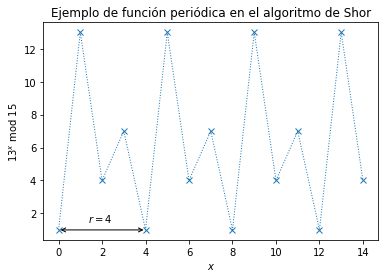

In [138]:
N = 15
a = 13

# Calculamos las x e yque vamos a dibujar
xvals = [i for i in range(N)]
yvals = [np.mod(a**x, N) for x in xvals]

# Usamos matplotlib para mostrarlo graficamente
fig, ax = plt.subplots()
ax.plot(xvals, yvals, linewidth=1, linestyle='dotted', marker='x')
ax.set(xlabel='$x$', ylabel='$%i^x$ mod $%i$' % (a, N),
       title="Ejemplo de función periódica en el algoritmo de Shor")
try: # Dibujamos el periodo r en el gráfico
    r = yvals[1:].index(1) +1 
    plt.annotate('', xy=(0,1), xytext=(r,1), arrowprops=dict(arrowstyle='<->'))
    plt.annotate('$r=%i$' % r, xy=(r/3,1.5))
except ValueError:
    print('No se pudo encontrar el período, comprobar que a < N y que no tenga factores comunes con N.')

## 3. Implementación con Qiskit

En este ejemplo resolveremos el problema de encontrar el período para $a=13$ y $N=15$. Daremos los circuitos para $U$ donde:

$$U|y\rangle = |ay\bmod 15\rangle $$

Para crear $U^x$, simplemente repetiremos el circuito $x$ veces. En la siguiente sección discutiremos un método general para crear estos circuitos de manera eficiente. La función `c_amod15` devuelve la puerta U controlada para `a`, repetidas veces `power`.

In [139]:
#La función c_amod15 devuelve la puerta U-controlada para a, tantes veces como `power`.
#Esta función es especifíca pora la operacion mod15 y así está implementada en el ordenador cuántico de IBM
#Solo funciona para los valores a = [2,4,7,8,11,13]
def c_amod15(a, power):
    """Multiplicacion-controlada para a mod 15"""
    if a not in [2,4,7,8,11,13]:
        raise ValueError("'a' debe ser 2,4,7,8,11 o 13")
    U = QuantumCircuit(4)        
    for iteration in range(power):
        if a in [2,13]:
            U.swap(0,1)
            U.swap(1,2)
            U.swap(2,3)
        if a in [7,8]:
            U.swap(2,3)
            U.swap(1,2)
            U.swap(0,1)
        if a in [4, 11]:
            U.swap(1,3)
            U.swap(0,2)
        if a in [7,11,13]:
            for q in range(4):
                U.x(q)
    U = U.to_gate()
    U.name = "%i^%i mod 15" % (a, power)
    c_U = U.control()
    return c_U

In [140]:
#Función que crea el circuito de la inversa de la transformada cuántica de Fourier
def qft_inversa(n):
    """n-qubit QFT-inversa para los primeros n qubits del circuito"""
    qc = QuantumCircuit(n)
    # Hay que realizar los swaps
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.cp(-np.pi/float(2**(j-m)), m, j)
        qc.h(j)
    qc.name = "QFT†"
    return qc

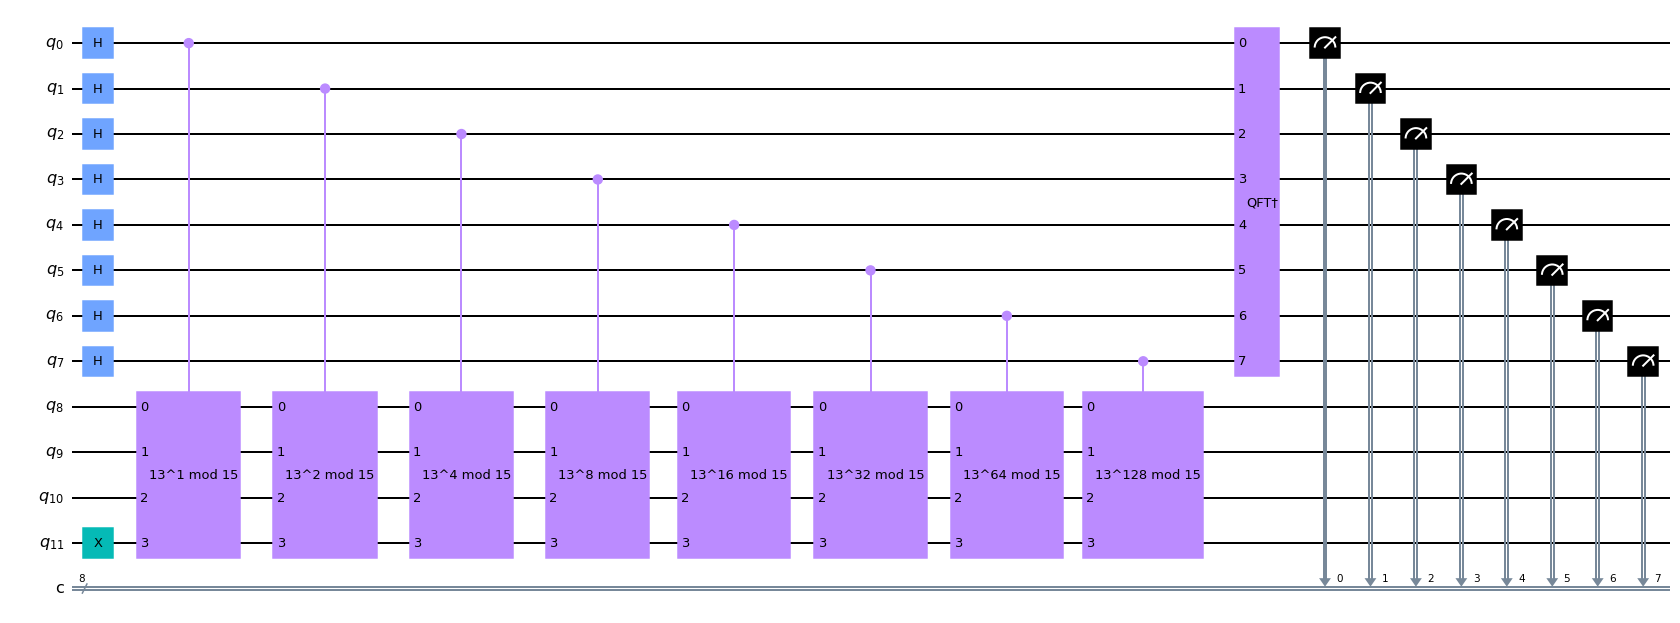

In [141]:
# Creamos el circuito cuántico (QuantumCircuit) con n_count qubits para el primer registro |x>
# más 4 qubits para el segundo registro |w> que actuar en U 
n_count = 8  # número de qubits necesarios para factorizar 15

qc = QuantumCircuit(n_count + 4, n_count)

# Inicializamos los n_count qubits al estado|+> aplicando la  puerta de Hadamard
for q in range(n_count):
    qc.h(q) #Aplicamos la puerta de Hadamard a cada qubit
    
# Definimos un registro auxiliar en el estado |1>
qc.x(3+n_count)

# Aplicamos la operación de U-controlada (que realizará la exponenciación modular)
for q in range(n_count):
    qc.append(c_amod15(a, 2**q), 
             [q] + [i+n_count for i in range(4)])

# Aplicamos la inversa-QFT a los 8 qubits del primer registro |x>
qc.append(qft_inversa(n_count), range(n_count))

# Medimos los n_count qubits
qc.measure(range(n_count), range(n_count))
qc.draw(output='mpl', fold=-1)

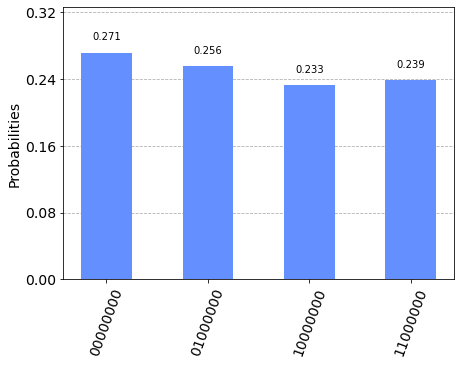

In [142]:
#Realizamos la simulación del circuito anterior
aer_sim = Aer.get_backend('aer_simulator') #Usamos el AerSimulator
t_qc = transpile(qc, aer_sim) #Pasamos el ciruito al simulador
qobj = assemble(t_qc) #Lo compilamos
results = aer_sim.run(qobj).result() #Hacemos la simulación y guardamos los resultados
counts = results.get_counts() #Obtenemos la distribución de los qubits finales despues del QPE 
plot_histogram(counts) #Hacemos la grafica con las probabilidades

In [143]:
filas, fases_medidas = [], []
for output in counts:
    decimal = int(output, 2)  # Convertimos (base 2) a decimal
    fase = decimal/(2**n_count)  # Encontramos el valor propio
    fases_medidas.append(fase)
    frac = Fraction(fase).limit_denominator(N)
    # Agragamos los valores por filas en la tabla
    filas.append([f"{output}(bin) = {decimal:>3}(dec)", 
                 f"{decimal}/{2**n_count} = {fase:.2f}", f"{frac.numerator}/{frac.denominator}", frac.denominator])
# Imprimimos la tabla
headers=["Registro de salida", "Fase",  "Fraccion", "Posible r"]
df = pd.DataFrame(filas, columns=headers)
print(df)

         Registro de salida            Fase Fraccion  Posible r
0  01000000(bin) =  64(dec)   64/256 = 0.25      1/4          4
1  11000000(bin) = 192(dec)  192/256 = 0.75      3/4          4
2  10000000(bin) = 128(dec)  128/256 = 0.50      1/2          2
3  00000000(bin) =   0(dec)    0/256 = 0.00      0/1          1


Como el estado computacional base  |1⟩  es una superposición de estos valores propios, significa que si aplicamos QPE en  𝑈  con el estado  |1⟩ , mediremos la fase:
𝜙=𝑠\𝑟
donde  $s$  es un entero cualquiera entre  $0$ y  $𝑟−1$ . Finalmente usamos el algoritmo de fracciones continuas con  𝜙  para encontrar 𝑟.
Por lo tanto, hemos usado el algoritmo de fracciones continuas para intentar encontrar $r$. Python tiene esta funcionalidad incorporada. 
Podemos ver que dos de los valores propios medidos nos dieron el resultado correcto: $r=4$, y podemos ver que el algoritmo de Shor tiene posibilidades de fallar. Estos malos resultados se deben a que $s = 0$, o porque $s$ y $r$ no son coprimos y en lugar de $r$ se nos da un factor de $r$. La solución más fácil para esto es simplemente repetir el experimento hasta que obtengamos un resultado satisfactorio por $r$.

In [144]:
#Circuito que recopila lo visto anteriorme para hacer la estimación de fase
#Le pasamos el parámetro de entrada a que es el número del cuál queremos saber su orden mod 15, devuelve la fase
def qpe_amod15(a):
    n_count = 8 #8 bits para el registro de entrada |x>
    qc = QuantumCircuit(4+n_count, n_count) #Creamos el circuito cuántico con |x> de 8 qubits y |w> de 4 qubits auxiliar
    for q in range(n_count):
        qc.h(q)     # Inicializamos los 8 qubits de |x> al estado |+> con puertas de Hadamard
    qc.x(3+n_count) # Ponemos el registro auxiliar en el estado |1>
    for q in range(n_count): # Aplicamos las puertas U-controladas de la exponenciación modular con modulo 15
        qc.append(c_amod15(a, 2**q), 
                 [q] + [i+n_count for i in range(4)])
    qc.append(qft_inversa(n_count), range(n_count)) # Aplicamos la QFT inversa
    qc.measure(range(n_count), range(n_count)) #Medimos los qubits finales del registro |x>
    # Simulamos los resultados obtenidos
    aer_sim = Aer.get_backend('aer_simulator')
    t_qc = transpile(qc, aer_sim)
    qobj = assemble(t_qc, shots=1)
    # Poniendo memory=True nos permite ver una lista secuencial de cada resultado
    result = aer_sim.run(qobj, memory=True).result() 
    lecturas = result.get_memory()
    print("Lectura del registro: " + lecturas[0])
    fase = int(lecturas[0],2)/(2**n_count) #Calculamos una de las posibles fases
    print("Fase correspondiente: %f" % fase)
    return fase 

In [145]:
#Algoritmo de Shor para recuperar los factores de N=15. Si no los encontramos volvemos a realizar la ejecución
factor_encontrado = False
intento = 0
while not factor_encontrado:
    intento += 1
    print("\nIntento %i:" % intento)
    fase = qpe_amod15(a) # Fase = s/r
    #El denominador después de hacer las fracciones continuas nos permite encontrar r, puede ser r o un divisor, por lo tanto no siempre funciona
    frac = Fraction(fase).limit_denominator(N) 
    r = frac.denominator
    print("Resultado: r = %i" % r)
    if fase != 0:
        # Los posibles factores son gcd(x^{r/2} ±1 , 15)
        posibles_factores = [gcd(a**(r//2)-1, N), gcd(a**(r//2)+1, N)]
        print("Factores posibles: %i and %i" % (posibles_factores[0], posibles_factores[1]))
        for factor in posibles_factores:
            if factor not in [1,N] and (N % factor) == 0: # Comprobamos si el posible factor es realmente un factor primo de N no trivial
                print("*** Factor no trivial encontrado: %i ***" % factor)
                factor_encontrado = True


Intento 1:
Lectura del registro: 00000000
Fase correspondiente: 0.000000
Resultado: r = 1

Intento 2:
Lectura del registro: 11000000
Fase correspondiente: 0.750000
Resultado: r = 4
Factores posibles: 3 and 5
*** Factor no trivial encontrado: 3 ***
*** Factor no trivial encontrado: 5 ***


## Implementación alternativa de QPE

Muchas de las demostraciones experimentales del algoritmo de Shor se basan en optimizaciones significativas basadas en el conocimiento a priori de los resultados esperados. Seguiremos la formulación para $N = 15$. A continuación se muestra la primera figura, que muestra varios circuitos cuánticos, Diagramas del algoritmo de Shor para factorizar $N = 15$, usando un enfoque de libro de texto genérico (**A**) comparado con el enfoque de Kitaev (**B** ) para una base genérica $a$. (**C**) La implementación real para factorizar $15$ con $a$ = $11$, optimizado para el estado de entrada única correspondiente. Aquí $q_i$ corresponde al qubit respectivo en el registro computacional. (**D**) Aproximación de Kitaev al algoritmo de Shor para las bases ${2, 7, 8, 13}$. Aquí, la aplicación optimizada del primer multiplicador es idéntico en los cuatro casos, y el último multiplicador se implementa con multiplicadores modulares completos, como se muestra en (**E**). En todos los casos, el único qubit QFT se usa tres veces, lo que, junto con los cuatro qubits en el registro de cálculo, totaliza siete qubits efectivos. (**E**) Diagramas de circuito de los multiplicadores modulares de la forma $a \bmod N$ para bases $a = {2, 7, 8, 11, 13}$

<img src="images/shoralgorithm.png" width="500 px" align="center">

Hay que tener en cuenta que no podemos ejecutar esta versión del algoritmo de Shor en un dispositivo IBM Quantum Experience en este momento, ya que actualmente carecemos de la capacidad de realizar mediciones anticipadas y restablecer qubits. Por lo tanto, solo construiremos los circuitos para ejecutarlos en los simuladores.

In [146]:
from qiskit import BasicAer, execute
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.tools.visualization import plot_histogram
import math

Construimos los circuitos $a^1 \bmod 15$ para $a = 2,7,8,11,13$ como en **E**:

In [147]:
# qc = circuito cuántico, qr = registro cuántico, cr = registro clásico, a = 2, 7, 8, 11 or 13
def circuit_amod15(qc,qr,cr,a):
    if a == 2:
        qc.cswap(qr[4],qr[3],qr[2])
        qc.cswap(qr[4],qr[2],qr[1])
        qc.cswap(qr[4],qr[1],qr[0])
    elif a == 7:
        qc.cswap(qr[4],qr[1],qr[0])
        qc.cswap(qr[4],qr[2],qr[1])
        qc.cswap(qr[4],qr[3],qr[2])
        qc.cx(qr[4],qr[3])
        qc.cx(qr[4],qr[2])
        qc.cx(qr[4],qr[1])
        qc.cx(qr[4],qr[0])
    elif a == 8:
        qc.cswap(qr[4],qr[1],qr[0])
        qc.cswap(qr[4],qr[2],qr[1])
        qc.cswap(qr[4],qr[3],qr[2])
    elif a == 11: 
        qc.cswap(qr[4],qr[2],qr[0])
        qc.cswap(qr[4],qr[3],qr[1])
        qc.cx(qr[4],qr[3])
        qc.cx(qr[4],qr[2])
        qc.cx(qr[4],qr[1])
        qc.cx(qr[4],qr[0])
    elif a == 13:
        qc.cswap(qr[4],qr[3],qr[2])
        qc.cswap(qr[4],qr[2],qr[1])
        qc.cswap(qr[4],qr[1],qr[0])
        qc.cx(qr[4],qr[3])
        qc.cx(qr[4],qr[2])
        qc.cx(qr[4],qr[1])
        qc.cx(qr[4],qr[0])

A continuación, construiremos el resto del circuito de búsqueda de períodos como en **D**:

In [148]:
def circuit_aperiod15(qc,qr,cr,a):
    if a == 11:
        circuit_11period15(qc,qr,cr)
        return
    
    # Inicializamos q[0] a |1> 
    qc.x(qr[0])

    # Aplicamos a**4 mod 15
    qc.h(qr[4])
    #   identidad controlada en los otros 4 qubits, que es lo mismo que no hacer nada
    qc.h(qr[4])
    #   medimos
    qc.measure(qr[4],cr[0])
    #   reinicializamos q[4] a |0>
    qc.reset(qr[4])

    # Aplicamos a**2 mod 15
    qc.h(qr[4])
    #   Unitaria controlada
    qc.cx(qr[4],qr[2])
    qc.cx(qr[4],qr[0])
    #   avanzamos
    qc.u1(math.pi/2.,qr[4]).c_if(cr, 1)
    qc.h(qr[4])
    #   medimos
    qc.measure(qr[4],cr[1])
    #   reinicializamos q[4] a |0>
    qc.reset(qr[4])

    # Aplicamos a mod 15
    qc.h(qr[4])
    #   Unitaria controlada
    circuit_amod15(qc,qr,cr,a)
    #   avanzamos
    qc.u1(3.*math.pi/4.,qr[4]).c_if(cr, 3)
    qc.u1(math.pi/2.,qr[4]).c_if(cr, 2)
    qc.u1(math.pi/4.,qr[4]).c_if(cr, 1)
    qc.h(qr[4])
    #   medimos
    qc.measure(qr[4],cr[2])

A continuación, construimos el circuito optimizado por $11 \bmod 15$ como en **C**.

In [149]:
def circuit_11period15(qc,qr,cr):
    # Aplicamos a**4 mod 15
    qc.x(qr[0])

    # Aplicamos a**4 mod 15
    qc.h(qr[4])
    #  identidad controlada en los otros 4 qubits, que es lo mismo que no hacer nada
    qc.h(qr[4])
    #   medimos
    qc.measure(qr[4],cr[0])
    #    reinicializamos q[4] a |0>
    qc.reset(qr[4])

    # Apply a**2 mod 15
    qc.h(qr[4])
    #   identidad controlada en los otros 4 qubits, que es lo mismo que no hacer nada
    #   avanzamos
    qc.u1(math.pi/2.,qr[4]).c_if(cr, 1)
    qc.h(qr[4])
    #   medimos
    qc.measure(qr[4],cr[1])
    #    reinicializamos q[4] a |0>
    qc.reset(qr[4])

    # Aplicamos 11 mod 15
    qc.h(qr[4])
    #   controlled unitary.
    qc.cx(qr[4],qr[3])
    qc.cx(qr[4],qr[1])
    #   avanzamos
    qc.u1(3.*math.pi/4.,qr[4]).c_if(cr, 3)
    qc.u1(math.pi/2.,qr[4]).c_if(cr, 2)
    qc.u1(math.pi/4.,qr[4]).c_if(cr, 1)
    qc.h(qr[4])
    #   medimos
    qc.measure(qr[4],cr[2])

<ipython-input-148-9211f6ebe889>:24: DeprecationWarning: The QuantumCircuit.u1 method is deprecated as of 0.16.0. It will be removed no earlier than 3 months after the release date. You should use the QuantumCircuit.p method instead, which acts identically.
  qc.u1(math.pi/2.,qr[4]).c_if(cr, 1)
<ipython-input-148-9211f6ebe889>:36: DeprecationWarning: The QuantumCircuit.u1 method is deprecated as of 0.16.0. It will be removed no earlier than 3 months after the release date. You should use the QuantumCircuit.p method instead, which acts identically.
  qc.u1(3.*math.pi/4.,qr[4]).c_if(cr, 3)
<ipython-input-148-9211f6ebe889>:37: DeprecationWarning: The QuantumCircuit.u1 method is deprecated as of 0.16.0. It will be removed no earlier than 3 months after the release date. You should use the QuantumCircuit.p method instead, which acts identically.
  qc.u1(math.pi/2.,qr[4]).c_if(cr, 2)
<ipython-input-148-9211f6ebe889>:38: DeprecationWarning: The QuantumCircuit.u1 method is deprecated as of 0.1

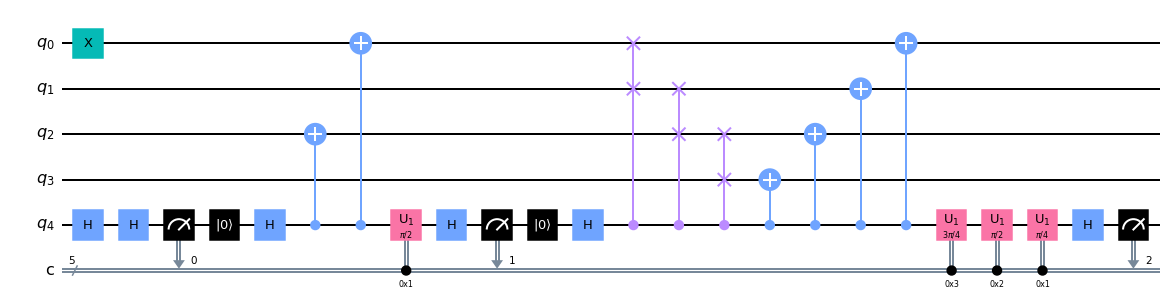

In [150]:
#caso con a=7
q = QuantumRegister(5, 'q')
c = ClassicalRegister(5, 'c')

shor = QuantumCircuit(q, c)
circuit_aperiod15(shor,q,c,7)
shor.draw(output='mpl')

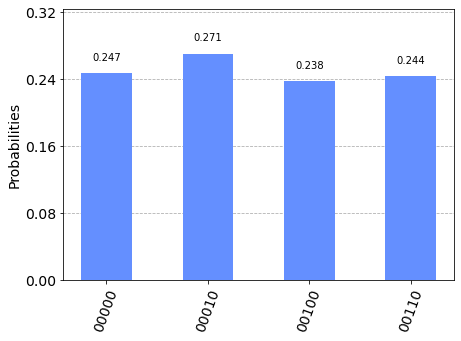

In [151]:
backend = BasicAer.get_backend('qasm_simulator')
sim_job = execute([shor], backend)
sim_result = sim_job.result()
sim_data = sim_result.get_counts(shor) 
plot_histogram(sim_data)
#vemos que todos los estados son equiprobables con probabilidad 0.25

In [152]:
#n_counts =4
n_counts =4
filas, fases_medidas = [], []
for output in sim_data:
    decimal = int(output, 2)  # Convertimos (base 2) a decimal
    fase = decimal/(2**3)  # Encontramos el valor propio usamos solo 4 qubits de entrada n_counts =4
    fases_medidas.append(fase)
    frac = Fraction(fase).limit_denominator(N)
    # Agragamos los valores por filas en la tabla
    filas.append([f"{output}(bin) = {decimal:>3}(dec)", 
                 f"{decimal}/{2**n_counts} = {fase:.2f}", f"{frac.numerator}/{frac.denominator}", frac.denominator])
# Imprimimos la tabla
headers=["Registro de salida", "Fase",  "Fraccion", "Posible r"]
df = pd.DataFrame(filas, columns=headers)
print(df)

      Registro de salida         Fase Fraccion  Posible r
0  00100(bin) =   4(dec)  4/16 = 0.50      1/2          2
1  00110(bin) =   6(dec)  6/16 = 0.75      3/4          4
2  00000(bin) =   0(dec)  0/16 = 0.00      0/1          1
3  00010(bin) =   2(dec)  2/16 = 0.25      1/4          4


Obtenemos en la mitad de los casos el orden $r$ correcto es decir 4, en un caso obtenmos un divisor ($2$) del orden y en el caso de 0 lo tenemos que repetir ya que no aporta información.

<ipython-input-149-1a144dfe0fc8>:18: DeprecationWarning: The QuantumCircuit.u1 method is deprecated as of 0.16.0. It will be removed no earlier than 3 months after the release date. You should use the QuantumCircuit.p method instead, which acts identically.
  qc.u1(math.pi/2.,qr[4]).c_if(cr, 1)
<ipython-input-149-1a144dfe0fc8>:31: DeprecationWarning: The QuantumCircuit.u1 method is deprecated as of 0.16.0. It will be removed no earlier than 3 months after the release date. You should use the QuantumCircuit.p method instead, which acts identically.
  qc.u1(3.*math.pi/4.,qr[4]).c_if(cr, 3)
<ipython-input-149-1a144dfe0fc8>:32: DeprecationWarning: The QuantumCircuit.u1 method is deprecated as of 0.16.0. It will be removed no earlier than 3 months after the release date. You should use the QuantumCircuit.p method instead, which acts identically.
  qc.u1(math.pi/2.,qr[4]).c_if(cr, 2)
<ipython-input-149-1a144dfe0fc8>:33: DeprecationWarning: The QuantumCircuit.u1 method is deprecated as of 0.1

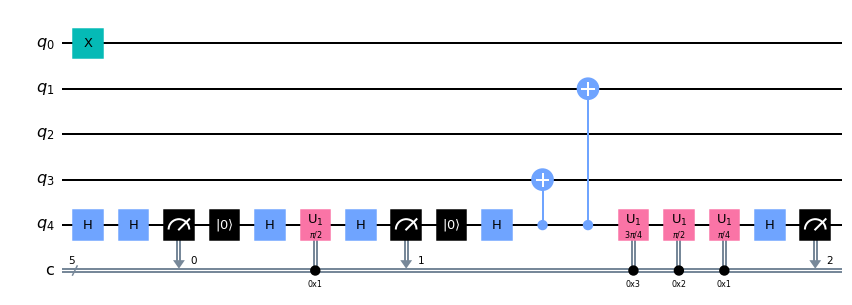

In [153]:
#caso con a=11
q = QuantumRegister(5, 'q')
c = ClassicalRegister(5, 'c')

shor = QuantumCircuit(q, c)
circuit_aperiod15(shor,q,c,11)
shor.draw(output='mpl')

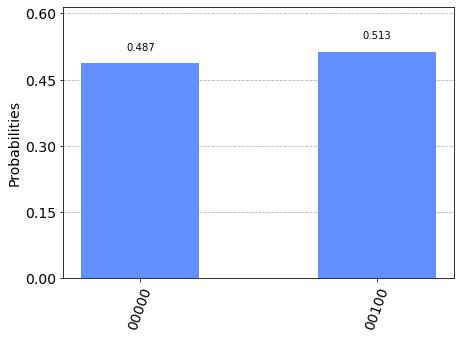

In [154]:
backend = BasicAer.get_backend('qasm_simulator')
sim_job = execute([shor], backend)
sim_result = sim_job.result()
sim_data = sim_result.get_counts(shor) 
plot_histogram(sim_data)

In [155]:
#n_counts =4
filas, fases_medidas = [], []
for output in sim_data:
    decimal = int(output, 2)  # Convertimos (base 2) a decimal
    fase = decimal/(2**n_counts)  # Encontramos el valor propio usamos solo 4 qubits de entrada
    fases_medidas.append(fase)
    frac = Fraction(fase).limit_denominator(N)
    # Agragamos los valores por filas en la tabla
    filas.append([f"{output}(bin) = {decimal:>3}(dec)", 
                 f"{decimal}/{2**n_counts} = {fase:.2f}", f"{frac.numerator}/{frac.denominator}", frac.denominator])
# Imprimimos la tabla
headers=["Registro de salida", "Fase",  "Fraccion", "Posible r"]
df = pd.DataFrame(filas, columns=headers)
print(df)

      Registro de salida         Fase Fraccion  Posible r
0  00100(bin) =   4(dec)  4/16 = 0.25      1/4          4
1  00000(bin) =   0(dec)  0/16 = 0.00      0/1          1


Podemos que aqui con la version simplificada en el caso de a=11, solo obtenemos dos posibles resultados de qubit con igual probabilidad de 0.5. El 0 y el 4 uno ya nos devuelve directamente el periodo y en el caso de obtener 0 tenemos que volver a ejecutar el algoritmo de QPE